In [1]:
import pandas as pd
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model as lm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim

In [2]:

class dataframe_preparator():
    def __init__(self):
        self._df = None
        
        self._months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        self._hours = [str(i) + ' AM' for i in range(1, 13)] + [str(i) + ' PM' for i in range(1, 13)]
        
        self._WEATHER_APPEARENCE = ['Any except rain', 'Any weather', 'Rain only']
        self._WEATHER_APPEARENCE_FISH = {'Yes': 'Any weather', 'No': 'Any except rain'}

        self._COLOR_TONES = {
            'Cold': ('Blue', 'Light Blue', 'Purple', 'Green'),
            'Neutral': ('Black', 'Beige', 'Gray', 'White'),
            'Warm': ('Brown', 'Orange', 'Red', 'Pink', 'Yellow')
        }
        
        self._UNWANTED_COLUMNS = [f'SH {month}' for month in self._months] + [
            'Unique Entry ID', 'Internal ID', 'Critterpedia Filename',
            'Furniture Filename', 'Icon Filename', 'Name', '#'
        ]
        
        self._SEASONS = {
            'Spring': ['NH ' + self._months[i] for i in range(0,3)],
            'Summer': ['NH ' + self._months[i] for i in range(3,6)],
            'Autumn': ['NH ' + self._months[i] for i in range(6,9)],
            'Winter': ['NH ' + self._months[i] for i in range(9,12)]
        }
        
        self._TIMESTAMPS = {
            'Midnight': ([self._hours[-1]]+ self._hours[0:3]),
            'Sunrise': (self._hours[3:7]),
            'Morning': (self._hours[7:11]),
            'Midday': (self._hours[11:15]),
            'Afternoon': (self._hours[15:19]),
            'Evening': (self._hours[19:23])
        }
        
        self._WHEREHOW_CORRESPONDENCE_PF = './data/where_how_correspondence.csv'
        
    
    # Método privado para establecer el dataframe
    def _set_df(self, df: pd.DataFrame | None = None, df_path: str | None = None, isFish: bool = False):
        # Verificamos que se haya enviado un dataframe
        if df is None and df_path is None:
            raise ValueError('Either df or df_path must be defined')
        
        # Si no mandaron el dataframe en raw, lo leemos del path
        if df is None:
            self._df = pd.read_csv(df_path)
        else:
            self._df = df
            
        # Eliminamos columnas no deseadas y específicas si es un pez
        columns_to_drop = self._UNWANTED_COLUMNS + (['Size', 'Shadow', 'Lighting Type'] if isFish else [])
        
        # Establecemos el dataframe de la clase al mismo
        self._df = self._df.drop(columns=columns_to_drop)
    
    
    # Método para el procesamiento
    def process(self, df: pd.DataFrame | None = None, df_path: str | None = None, isFish: bool = False) -> pd.DataFrame:
        # Establecemos el df
        self._set_df(df=df, df_path=df_path, isFish=isFish)
        
        # Procesamos
        self._process_months()
        self._process_colors()
        self._process_weather(isFish)
        self._process_where_how()
        self._process_spawn_rate()
        
        # Devolvemos el nuevo dataframe
        return self._df
    
    # Método privado para el procesamiento de los meses
    def _process_months(self):        
        # Selecciona las columnas de meses
        monthly_columns = self._df.loc[:, 'NH Jan':'NH Dec']

        # Si no hay columnas o han sido borradas, no procesamos el dataframe
        if monthly_columns is None:
            return 
        
        self._process_seasons(monthly_columns)
        self._process_timestamps(monthly_columns)

        self._df = self._df.drop(columns=monthly_columns)
  

    # Método privado para el procesamiento de las estaciones
    def _process_seasons(self, monthly_columns):
        # Inicializa columnas de temporadas en el DataFrame
        for season in self._SEASONS:
            self._df[season] = 0

        # Miramos todas las columnas en el df
        for index, row in monthly_columns.iterrows():
            # Almacenamos la cuenta de la aparición de cada estación en base a los meses
            season_counts = {season: 0 for season in self._SEASONS}

            for col in monthly_columns.columns:
                value = row[col]
                
                # En caso de que la columna no contenga ningun valor, pasamos de ella
                if not pd.notna(value):
                    continue
                
                # Si no, hacemos la cuenta
                for season, season_values in self._SEASONS.items():
                    if col in season_values:
                        season_counts[season] += 1

            # Si hay al menos 2 meses activos para una temporada, marca con 1
            for season in self._SEASONS:
                if season_counts[season] >= 2:
                    self._df.at[index, season] = 1
    
    # Método privado para el procesamiento de las horas         
    def _process_timestamps(self, monthly_columns):
        # Inicializa columnas de temporadas en el DataFrame
        for timestamp in self._TIMESTAMPS:
            self._df[timestamp] = 0

        # Miramos todas las columnas en el df
        for index, row in monthly_columns.iterrows():
            # Almacenamos la cuenta de la aparición de cada estación en base a los meses
            timestamp_counts = {timestamp: 0 for timestamp in self._TIMESTAMPS}

            for col in monthly_columns.columns:
                value = row[col]

                # En caso de que la columna no contenga ningun valor, pasamos de ella
                if not pd.notna(value):
                    continue
                
                # Ponemos el valor máximo en caso de que se marque all day a todos los timestamps
                if value.lower() == 'all day':
                    for timestamp in self._TIMESTAMPS:
                        timestamp_counts[timestamp] = 4 
                    continue
                
                # Si no, primero sacamos un array que contenga todas las horas entre las franjas
                check_twice = value.split(';')
                
                values = []
                
                for i in range(len(check_twice)):
                    cleaned_value = check_twice[i].replace('\xa0', ' ').replace('–', '-').strip()
                    split_value = cleaned_value.split(' - ')
                    initial_value = self._hours.index(split_value[0])
                    hours = self._hours[initial_value:] + self._hours[:initial_value]
                    initial_value = 0
                    final_value = hours.index(split_value[1])
                    values  += hours[initial_value:final_value]                

                # Y calculamos
                for timestamp, timestamp_values in self._TIMESTAMPS.items():
                    for val in values:
                        if val in timestamp_values:
                            timestamp_counts[timestamp] += 1
            # Si hay al menos 2 horas activos para una timestamp, marca con 1
            for timestamp in self._TIMESTAMPS:
                if timestamp_counts[timestamp] >= 2:
                    self._df.at[index, timestamp] = 1
    
    # Método privado para el procesamiento de los colores
    def _process_colors(self):
        # Creamos las columnas con valores iniciales de 0
        self._df[[tone for tone in self._COLOR_TONES]] = 0
        
        for index, row in self._df.iterrows():
            # Extraemos los colores de la fila
            colors_row = [row['Color 1'], row['Color 2']]
            
            # Iteramos sobre los tonos y valores asociados
            for tone, tone_values in self._COLOR_TONES.items():
                # Comprobamos cuántos colores coinciden con los valores de cada tono
                for color in colors_row:
                    if color in tone_values:
                        self._df.at[index, tone] += 1
        
        # Eliminamos las columnas de Color 1 y Color 2
        self._df = self._df.drop(columns=['Color 1', 'Color 2'])

    
    # Método privado para el procesamiento del atributo weather
    def _process_weather(self, isFish:bool):
        # Creamos las columnas con valores iniciales de 0
        self._df[[weather for weather in self._WEATHER_APPEARENCE]] = 0
        
        # El nombre y procesamiento de la columna varía si es pez o no
        if not isFish:
            for index, row in self._df.iterrows():
                # Iteramos por las opciones de clima
                for weather in self._WEATHER_APPEARENCE:
                    # Si el weather de esa fila se corresponde con el de la iteracion le ponemos el valor a 1 y pasamos al siguiente
                    if row['Weather'] == weather:
                        self._df.at[index, weather] = 1
                        continue
                    
            # Eliminamos la columan Weather de la tabla
            self._df = self._df.drop(columns=['Weather'])
        
        # Hacemos la casuística para los peces
        else:
            for index, row in self._df.iterrows():
                # Iteramos por las opciones de clima de pez
                for weather, weather_values in self._WEATHER_APPEARENCE_FISH.items():
                    # Si el weather de esa fila se corresponde con el de la iteracion le ponemos el valor a 1 y pasamos al siguiente
                    if row['Rain/Snow Catch Up'] == weather:
                        self._df.at[index, weather_values] = 1
                        continue
                    
            # Eliminamos la columan Weather de la tabla
            self._df = self._df.drop(columns=['Rain/Snow Catch Up'])
    
    def _process_where_how(self):
        # Creamos la columna vacía
        self._df[['Appearance Location']] = 0
        
        # Así como un diccionario donde almacenar los datos leídos del archivo
        wherehow_dict = {} 
        
        # Probamos a leer el archivo y nos mantenemos al loro por si ocurriera un error
        try:
            # Abre el archivo CSV
            with open(self._WHEREHOW_CORRESPONDENCE_PF, 'r') as lines:
                for line in lines:
                    # Separa la línea por puntos y comas y quita saltos de línea
                    line_value = line.strip().split(';')
                    
                    # Comprobamos que no haya un error de formato en el texto (más de un ;)
                    if len(line_value) > 2:
                        raise ValueError(f"Error de formato en la linea {line_value} a la hora de procesar la información de Where/How")
                    
                    # El primer valor será la clave y el segundo el valor
                    key = line_value[0]  
                    value = line_value[1] 

                    # Añadir la clave y el valor al diccionario
                    wherehow_dict[key] = value

        # De ocurrir un error, lanzamos otro con un mensaje custom indicando la raíz del error
        except FileNotFoundError:
            raise ValueError('File corresponding to where how information not found on ./data/')

        # Iteramos por las lineas del dataframe
        for index, row in self._df.iterrows():
            # Ingresamos los valores según las columnas
            self._df.at[index, 'Appearance Location'] = int(wherehow_dict[row['Where/How']])
        
        # Eliminamos el atributo where/how
        self._df = self._df.drop(columns=['Where/How'])
    
    def _process_spawn_rate(self):
        
        # Iteramos por las lineas del dataframe
        for index, row in self._df.iterrows():
            # Dividimos la variable de ser posible
            values = row['Spawn Rates'].split('–')
            # Si hay más de un valor hacemos la media y la asignamos
            if len(values) > 1:
                numbers = [int(value.strip()) for value in values]
                average = sum(numbers) / len(numbers)
                self._df.at[index, 'Spawn Rates'] = int(average)

    # Método para obtener el dataframe
    def get_df(self):
        return self._df
    
    # Método que une dataframes
    def join_dataframe(self, dataframe:pd.DataFrame):
        return pd.concat([self._df, dataframe], ignore_index=True)


df_prep = dataframe_preparator()

insects_dataframe = df_prep.process(df_path='./data/insects.csv', isFish=False)
fish_dataframe = df_prep.process(df_path='./data/fish.csv', isFish=True)
dataframe = df_prep.join_dataframe(insects_dataframe)
dataframe


,Sell,Total Catches to Unlock,Spawn Rates,Spring,Summer,Autumn,Winter,Midnight,Sunrise,Morning,Midday,Afternoon,Evening,Cold,Neutral,Warm,Any except rain,Any weather,Rain only,Appearance Location
0,200,0,3,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,6
1,3000,20,3,0,1,1,0,1,1,1,0,1,1,0,1,1,1,0,0,5
2,10000,50,1,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,0,5
3,10000,50,1,0,0,1,0,1,1,1,0,1,1,0,1,1,1,0,0,5
4,5000,20,4,0,1,1,1,1,1,1,1,1,1,0,2,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,600,20,10,0,0,1,0,1,1,1,1,1,1,2,0,0,0,1,0,10
156,600,20,10,0,0,1,1,0,1,0,0,1,0,0,0,2,0,1,0,10
157,2500,0,0,1,1,1,1,1,1,1,1,1,1,0,0,2,0,1,0,10
158,200,0,20,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,3


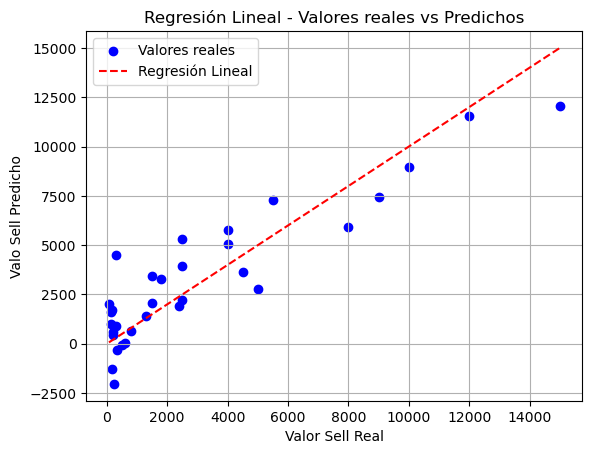

^=================================================
Precision: 82.32%
Error cuadrático medio: 2553535.02
Error absoluto medio: 1302.71




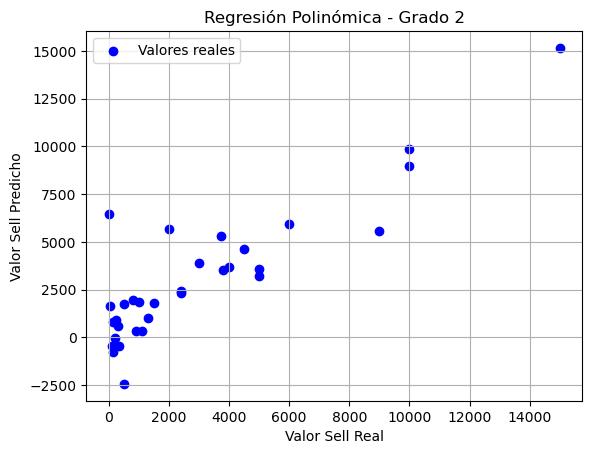

^=================================================
Precision: 76.65%
Error cuadrático medio: 2974948.90
Error absoluto medio: 1100.88





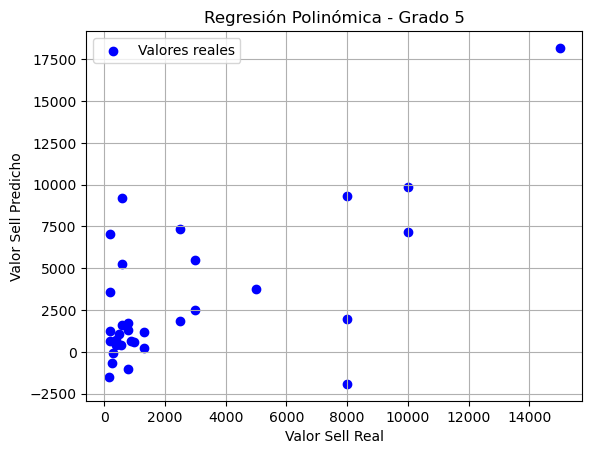

^=================================================
Precision: 20.51%
Error cuadrático medio: 11058268.58
Error absoluto medio: 2133.06




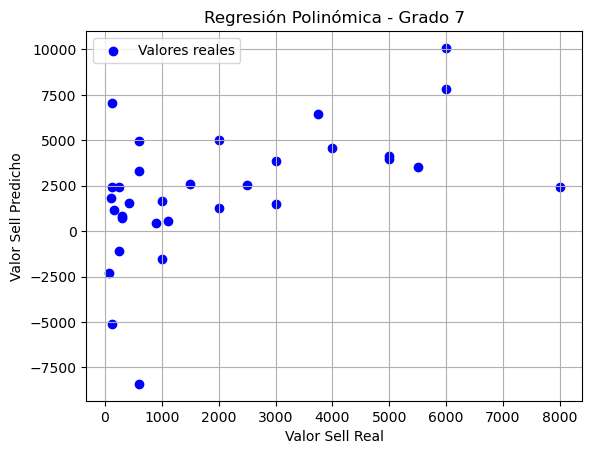

^=================================================
Precision: -89.98%
Error cuadrático medio: 9102330.29
Error absoluto medio: 2227.24
******************************************************************

=============== Regresión Lineal ===============
Precisión media: 65.27%
Error absoluto medio: 1530.58u
Tiempo tomado: 0.57s


=============== Regresión Polinomial (2) ===============
Precisión media: 69.86%
Error absoluto medio: 1440.72u
Tiempo tomado: 0.70s


=============== Regresión Polinomial (5) ===============
Precisión media: 45.95%
Error absoluto medio: 1932.27u
Tiempo tomado: 22.40s


=============== Regresión Polinomial (7) ===============
Precisión media: 42.92%
Error absoluto medio: 2014.71u
Tiempo tomado: 347.77s




In [3]:
class regression_models():
    def __init__(self):
        self._data = None
        self._train_data = None
        self._test_data = None
        self._train_results = None
        self._test_results = None
        self._model = None
    
    # Método que se encarga de verificar que el dataframe proporcionado es un dataframe y no está vacio
    def _verify_data(self, data:pd.DataFrame) -> None:
        # Verificamos que se trate de un dataframe no nulo
        if not isinstance(data, pd.DataFrame) or data.empty: 
            raise ValueError("No valid DataFrame provided")
        
        # Hacemos la asignación 
        self._data = data
    
    # Método que normaliza los datos, salvo el precio
    def _normalize_data(self) -> None:
        # Definimos el normalizador habitual (MinMaxScaler)
        min_max_scaler = preprocessing.MinMaxScaler()
        
        # Guardamos la columna de Sell
        sell_column = self._data['Sell'].copy()
        
        # Guardamos el nombre de las columnas
        column_names = self._data.columns
        
        # Normalizamos los datos y los reconvertimos a DataFrame manteniendo el nombre de las columnas
        normalized_data = pd.DataFrame(
            min_max_scaler.fit_transform(self._data),
            columns=column_names
        )
        
        # Modificamos el valor de la columna Sell para que tenga los valores sin normalizar
        normalized_data['Sell'] = sell_column
        
        # Reescribimos la variable Data
        self._data = normalized_data[self._data.columns]
    
    # Método privado para la preparación de los datos
    def _prepare_data(self, test_size:float = 0.2) -> None:
        # Normalizamos los datos
        self._normalize_data()
        
        # Preparamos el sample de test y de train
        self._train_data, self._test_data = train_test_split(self._data, test_size=test_size)
        
        # Aislamos la columna a predecir (Precio)
        self._train_results = self._train_data[['Sell']]
        self._test_results = self._test_data[['Sell']]
        
        # Eliminamos la columna a predecir (Precio)
        self._train_data = self._train_data.drop(columns=['Sell'])
        self._test_data = self._test_data.drop(columns=['Sell'])
        
        # Nos aseguramos de que todas las columnas tienen el titulo en texto
        self._train_data.columns = self._train_data.columns.astype(str)
        self._train_results.columns = self._train_results.columns.astype(str)
        self._test_data.columns = self._test_data.columns.astype(str)
        self._test_results.columns = self._test_results.columns.astype(str)

        
    # Método abstracto y privado donde se especifica la implementación según la extensión    
    @abstractmethod
    def _regression(self) -> None:
        pass        
    
    # Método privado que obtiene la precisión en base al modelo usado
    def _get_precision(self) -> float: 
        _test_predictions = self._model.predict(self._test_data)

        test_r2 = r2_score(self._test_results, _test_predictions)
    
        # MSE (Mean Squared Error) → Cuanto más bajo, mejor
        test_mse = mean_squared_error(self._test_results, _test_predictions)
        
        # MAE (Mean Absolute Error) → Cuanto más bajo, mejor
        test_mae = mean_absolute_error(self._test_results, _test_predictions)
        
        return (test_r2*100, test_mse, test_mae)
    
    # Método público que realiza todos los cálculos
    def compute(self, data:pd.DataFrame) -> float:
        self._verify_data(data)
        self._prepare_data()
        self._regression()
        return self._get_precision()
    
    # Método público y abstracto encargado de hacer el plot del último dataframe o si no de uno nuevo
    @abstractmethod
    def show_plot(self, data:pd.DataFrame | None = None):
        pass
        
        
# Particularización de la clase regression_models para el modelo de regresión linear
class linear_regression(regression_models):
    
    # Implementación del método de regresión
    def _regression(self) -> None:
        # Creamos el regresador
        lin_reg = lm.LinearRegression()
        # Lo entrenamos
        lin_reg.fit(self._train_data, self._train_results)
        # Lo establecemos como modelo de la clase
        self._model = lin_reg
    
    # Implementación del método plot
    def show_plot(self, data: pd.DataFrame | None = None):
        # Verificamos que se trabaje sobre un dataset viejo o no
        if data is not None:
            self.compute(data)
        
        # Predicciones sobre el test set        
        test_pred = self._model.predict(self._test_data).ravel()
        test_actual = self._test_results['Sell'].values.ravel()

        # Gráfica
        plt.scatter(test_actual, test_pred, color='blue', label='Valores reales')
        plt.plot([test_actual.min(), test_actual.max()], 
                 [test_actual.min(), test_actual.max()], 
                 'r--' ,label='Regresión Lineal')
        plt.title('Regresión Lineal - Valores reales vs Predichos')
        plt.xlabel('Valor Sell Real')
        plt.ylabel('Valo Sell Predicho')
        plt.legend()
        plt.grid(True)
        plt.show()


# Particularización de la clase regression_models para el modelo de regresión polinomial        
class polynomial_regression(regression_models):
    
    # Constructor de la clase específico
    def __init__(self, degree:int=2):
        # Mandamos los datos a la clase madre
        super().__init__()
        # Definimos atributos propios
        self._degree = degree
        
    # Implementación del método de regresión
    def _regression(self)-> None:
        # Definimos un transformador para operar con polinomios
        self._poly_features = preprocessing.PolynomialFeatures(self._degree)
        
        # Transformar los datos
        self._train_data = self._poly_features.fit_transform(self._train_data)
        self._test_data = self._poly_features.transform(self._test_data)
        
        # Usar regresión ridge para evitar overfitting (Basada en mínimos cuadrados)
        pol_reg = lm.Ridge(alpha=1.0)
        # Entrenamos el modelo
        pol_reg.fit(self._train_data, self._train_results)
        
        # Definimos el modelo de la clase para predicciones
        self._model = pol_reg
        
    # Implementación del método de plot
    def show_plot(self, data: pd.DataFrame | None = None):
        # Verificamos que se trabaje sobre datos viejos
        if data is not None:
            self.compute(data)

        # Cogemos el valor de los resultados y lo transformamos a numpy
        X_plot = self._test_results.iloc[:, 0].values
        
        # Hacemos una predicción en base al modelo
        y_test_pred = self._model.predict(self._test_data).ravel()

        # Ordenamos los datos
        sort_idx = np.argsort(X_plot)
        X_sorted = X_plot[sort_idx]
        y_pred_sorted = y_test_pred[sort_idx]
        

        # Gráfica
        plt.scatter(X_sorted, y_pred_sorted, color='blue', label='Valores reales')
        plt.title(f'Regresión Polinómica - Grado {self._degree}')
        plt.xlabel('Valor Sell Real')
        plt.ylabel('Valor Sell Predicho')
        plt.legend()
        plt.grid(True)
        plt.show()


def compute_avg_values(n:int, model:regression_models, data: pd.DataFrame):
    avg_total = []
    mae_total = []
    
    t0 = time.time()
    for i in range(n):
        total = model.compute(dataframe)
        avg_total.append(total[0])
        mae_total.append(total[2])
    t1 = time.time()
    
    avg = sum(avg_total)/len(avg_total)
    mae = sum(mae_total)/len(mae_total)
    
    return avg, mae, t1-t0


# Uso de los diferentes modelos

# Modelo de regresión lineal
lin_model = linear_regression()
res = lin_model.compute(dataframe)
lin_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("\n")

# Modelos de regresión polinomial
pol_model = polynomial_regression(2)
res = pol_model.compute(dataframe)
pol_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("\n\n")

pol_model = polynomial_regression(5)
res = pol_model.compute(dataframe)
pol_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("\n")

pol_model = polynomial_regression(7)
res = pol_model.compute(dataframe)
pol_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("******************************************************************\n")


print("=============== Regresión Lineal ===============")
lin_model = linear_regression()
avg, mae, t = compute_avg_values(100, lin_model, dataframe)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")

print("=============== Regresión Polinomial (2) ===============")
pol_model = polynomial_regression(2)
avg, mae, t = compute_avg_values(100, pol_model, dataframe)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")

print("=============== Regresión Polinomial (5) ===============")
pol_model = polynomial_regression(5)
avg, mae, t = compute_avg_values(100, pol_model, dataframe)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")

print("=============== Regresión Polinomial (7) ===============")
pol_model = polynomial_regression(7)
avg, mae, t = compute_avg_values(100, pol_model, dataframe)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")



In [33]:
class FeedforwardNeuralNetModel(nn.Module):
    # Definimos el constructor
    def __init__(self, dataframe: pd.DataFrame, epochs=100, using_relu:bool=False, dropout:float=0.1):
        # Iniciamos la clase madre
        super().__init__()
        self._criterion = nn.MSELoss()

        self._data = dataframe
        self._epochs = epochs
        self.dropout_prob = dropout
        self._using_relu = using_relu

        # Configuración de parámetros fijos
        self.hidden_dim = 128
        self.learning_rate = 0.001

        # Preparamos los datos antes de empezar el procesamiento
        self._prepare_data()
        self._create_layers()

        # Y el optimizador, donde usamos Adam debido a la eficiencia
        self._optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

    def _prepare_data(self, test_size: float = 0.2):
        # Usamos RobustScaler para acotar los datos, de manera que se escalen acorde al IQR (rango entre quartiles)
        self.scaler = preprocessing.RobustScaler()
        scaled_data = self.scaler.fit_transform(self._data)
        self._data = pd.DataFrame(scaled_data, columns=self._data.columns)

        # Dividimos entreno y test
        train, test = train_test_split(self._data, test_size=test_size)

        # Convertir a tensores
        self.data_train = torch.FloatTensor(train.drop('Sell', axis=1).values)
        self.results_train = torch.FloatTensor(train['Sell'].values).view(-1, 1)
        self.data_test = torch.FloatTensor(test.drop('Sell', axis=1).values)
        self.data_test = torch.FloatTensor(test['Sell'].values).view(-1, 1)

    def _create_layers(self):
        # Obtenemos las dimensiones de entrada
        input_dim = self.data_train.shape[1]

        # Selección de función de activación basada en la preferencia
        activation = nn.ReLU() if self._using_relu else nn.LeakyReLU(0.01)

        # Construcción dinámica de capas
        layers = []
        layers.append(nn.Linear(input_dim, self.hidden_dim))

        # Primera capa oculta
        layers.append(activation)
        if self.dropout_prob > 0:
            layers.append(nn.Dropout(self.dropout_prob))

        # Segunda capa oculta
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        layers.append(activation)
        if self.dropout_prob > 0:
            layers.append(nn.Dropout(self.dropout_prob/2))  # Menor dropout en capas más profundas

        # Capa de salida
        layers.append(nn.Linear(self.hidden_dim, 1))

        # Construimos la red
        self.network = nn.Sequential(*layers)

        # Inicialización de pesos adaptada a la función de activación
        self._initialize_weights()

    #???
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if self._using_relu:
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # Función que define el feedforward. Esta, en torch, es llamada automáticamente al hacer self()
    def forward(self, x):
        return self.network(x)

    def fit(self):
        # Llamamos a la funcion entreno de la clase madre
        self.train()
        # Por cada epoch
        for epoch in range(self._epochs):
            # Optimizamos
            self._optimizer.zero_grad()
            # Feedforward
            outputs = self(self.data_train)
            # Definimos la pérdida
            loss = self._criterion(outputs, self.results_train)
            # Corregimos en base a la pérdida
            loss.backward()

            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

            # ??
            self._optimizer.step()

            # Mostramos los mensajes de progreso en el entreno
            if (epoch+1) % 50 == 0:
                print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

    def evaluate(self):
        # Método de la clase madre
        self.eval()
        # Evitando importar arriba
        with torch.no_grad():
            # Las predicciones son el resultado del feedforward
            predictions = self(self.data_test)
            # Definimos la pérdida
            loss = self._criterion(predictions, self.data_test)

            # Convertir a escala original
            test_data = np.concatenate([self.data_test.numpy(), self.data_test.numpy()], axis=1)
            pred_data = np.concatenate([self.data_test.numpy(), predictions.numpy()], axis=1)

            y_true = self.scaler.inverse_transform(test_data)[:, -1]
            y_pred = self.scaler.inverse_transform(pred_data)[:, -1]

            # Cálculo de métricas
            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            relative_error = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
            median_error = np.median(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

            # Muestreo
            print(f'\n=== Métricas Finales ===')
            print(f'- MSE: {mse:.4f}')
            print(f'- MAE: {mae:.4f}')
            print(f'- R²: {r2:.4f}')
            print(f'- Precisión Media: {100 - relative_error:.2f}%')
            print(f'- Precisión Mediana: {100 - median_error:.2f}%')
            print(f'- Función Activación: {"ReLU" if self._using_relu else "LeakyReLU"}')
            print(f'- Dropout: {self.dropout_prob}')

            return y_pred, 100-relative_error, 100 - median_error

# Pruebas comparativas
configs = [
    {"using_relu": False, "dropout": 0.0, "name": "LeakyReLU, sin Dropout"},
    {"using_relu": False, "dropout": 0.1, "name": "LeakyReLU, con Dropout"},
    {"using_relu": True, "dropout": 0.0, "name": "ReLU, sin Dropout"},
    {"using_relu": True, "dropout": 0.1, "name": "ReLU, con Dropout"}
]

evaluations = {
    "mean_precission":[],
    "median_precission":[],
    "model":[]
}

for config in configs:
    print(f"\n\n========== {config['name']} ==========")
    model = FeedforwardNeuralNetModel(
        dataframe=dataframe,
        epochs=500,
        using_relu=config['using_relu'],
        dropout=config['dropout']
    )
    model.fit()
    predictions, mean_precission, median_precission = model.evaluate()
    evaluations['mean_precission'].append(mean_precission)
    evaluations['median_precission'].append(median_precission)
    evaluations['model'].append(config['name'])

top_median = max(evaluations['median_precission'])
index_top_median = evaluations['median_precission'].index(top_median)
top_mean = evaluations['mean_precission'][index_top_median]

bot_median = min(evaluations['median_precission'])
index_bot_median = evaluations['median_precission'].index(bot_median)
bot_mean = evaluations['mean_precission'][index_bot_median]

print(f"\n\n============== Precisión máxima ==============")
print(f"\tModelo: {evaluations['model'][index_top_median]}")
print(f"\tMedia: {top_mean:.2f}%")
print(f"\tMediana: {top_median:.2f}%")

print(f"\n ============== Precisión mínima ==============")
print(f"\tModelo: {evaluations['model'][index_bot_median]}")
print(f"\tMedia: {bot_mean:.2f}%")
print(f"\tMediana: {bot_median:.2f}%")




========== LeakyReLU, sin Dropout ==========
Epoch 50, Loss: 0.022587
Epoch 100, Loss: 0.013887
Epoch 150, Loss: 0.011592
Epoch 200, Loss: 0.009892
Epoch 250, Loss: 0.008175
Epoch 300, Loss: 0.006909
Epoch 350, Loss: 0.005776
Epoch 400, Loss: 0.005080
Epoch 450, Loss: 0.004965
Epoch 500, Loss: 0.004936

=== Métricas Finales ===
- MSE: 2.8927
- MAE: 1.1045
- R²: 0.8230
- Precisión Media: 84.88%
- Precisión Mediana: 91.75%
- Función Activación: LeakyReLU
- Dropout: 0.0


========== LeakyReLU, con Dropout ==========
Epoch 50, Loss: 0.051395
Epoch 100, Loss: 0.057501
Epoch 150, Loss: 0.034226
Epoch 200, Loss: 0.037996
Epoch 250, Loss: 0.050192
Epoch 300, Loss: 0.027014
Epoch 350, Loss: 0.037248
Epoch 400, Loss: 0.022816
Epoch 450, Loss: 0.022108
Epoch 500, Loss: 0.026199

=== Métricas Finales ===
- MSE: 1.5377
- MAE: 0.8519
- R²: 0.9059
- Precisión Media: 89.52%
- Precisión Mediana: 91.93%
- Función Activación: LeakyReLU
- Dropout: 0.1


========== ReLU, sin Dropout ==========
Epoch 50, 